## Allen-Cahn 1D DeepONet (PyTorch)
This notebook ports the TensorFlow DeepONet example to PyTorch: it defines trunk/branch MLPs, an energy-based physics-informed loss, and trains on Gaussian-process generated input curves.

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='mps')

### Model: FNN and ONet

In [14]:
class FNN(nn.Module):
    def __init__(self, n_output: int, n_layer: int, n_nodes: int, activation: str = 'tanh'):
        super().__init__()
        acts = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'sigmoid': nn.Sigmoid(),
            'identity': nn.Identity(),
        }
        act = acts.get(activation, nn.Tanh())

        layers = []
        layers.append(nn.LazyLinear(n_nodes))
        layers.append(act)
        for _ in range(n_layer - 1):
            layers.append(nn.Linear(n_nodes, n_nodes))
            layers.append(act)
        self.hidden = nn.Sequential(*layers)
        self.out = nn.Linear(n_nodes, n_output)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.hidden(x)
        return self.out(y)


class ONet(nn.Module):
    def __init__(self, trunk: FNN, branch: FNN):
        super().__init__()
        self.trunk = trunk
        self.branch = branch

    def forward(self, u: torch.Tensor, x: torch.Tensor, return_grad: bool = False):
        # u: (B, Nu_s) sampled values for branch; x: (Nx, 1) grid points
        u_branch = self.branch(u)  # (B, n_feat)

        if return_grad:
            if not x.requires_grad:
                x = x.clone().detach().requires_grad_(True)
            u_trunk = self.trunk(x)  # (Nx, n_feat)
            n_feat = u_trunk.shape[1]
            grads_cols = []
            for i in range(n_feat):
                g = torch.autograd.grad(
                    outputs=u_trunk[:, i].sum(), inputs=x, create_graph=True, retain_graph=True
                )[0]  # (Nx,1)
                grads_cols.append(g[:, 0].unsqueeze(0))  # (1,Nx)
            du_cols = torch.cat(grads_cols, dim=0)  # (n_feat,Nx)

            u_out = torch.matmul(u_branch, u_trunk.T)  # (B,Nx)
            du_x = torch.matmul(u_branch, du_cols)    # (B,Nx)

            mask = ((x - 1.0) * (x + 1.0)).T  # (1,Nx)
            dmask = (2.0 * x).T                 # (1,Nx)
            u_phys = u_out * mask
            du_phys = du_x * mask + u_out * dmask
            return u_phys, du_phys
        else:
            u_trunk = self.trunk(x)
            u_out = torch.matmul(u_branch, u_trunk.T)
            mask = ((x - 1.0) * (x + 1.0)).T
            return u_out * mask


### Loss: Energy + Data distance

In [4]:
def Fe(u: torch.Tensor) -> torch.Tensor:
    return ((u**2 - 1.0) ** 2) / 4.0

def physics_informed_loss_sampled(onet: ONet, uks: torch.Tensor, uk: torch.Tensor, x: torch.Tensor, eps: float, tao: float):
    u_pred, du_x = onet(uks, x, return_grad=True)
    L_energy = torch.mean(0.5 * du_x**2 + Fe(u_pred) / (eps**2))
    L_distance = torch.mean((uk - u_pred)**2) / tao / 2.0
    return L_energy, L_distance


### Data: Gaussian process curves and discretized x

In [5]:
def gaussian_process(x: np.ndarray, num_curves: int, length_scale_list, u_mean: float = 0.0):
    X = x.reshape(-1, 1)
    ys = []
    for _ in range(num_curves):
        length_scale = np.random.choice(length_scale_list)
        d2 = (X - X.T) ** 2
        cov = np.exp(-0.5 * d2 / (length_scale**2))
        yst = np.random.multivariate_normal(mean=u_mean * np.ones(len(X)), cov=cov, size=1)
        if len(ys) == 0:
            ys = yst
        else:
            ys = np.vstack((ys, yst))
    return ys

def x_train(Nx: int) -> torch.Tensor:
    x = np.linspace(-1.0, 1.0, Nx).reshape(-1, 1).astype(np.float32)
    return torch.from_numpy(x)

def u_train(x: torch.Tensor, Nu: int, length_scale_list, u_mean: float = 0.0) -> torch.Tensor:
    x_np = x[:, 0].cpu().numpy()
    u = gaussian_process(x_np, Nu, length_scale_list, u_mean)
    u = 0.8 * u * (x_np + 1.0) * (x_np - 1.0)
    u = np.exp(1.5 * (1 - np.abs(u))) * u
    return torch.from_numpy(u.astype(np.float32))


### Hyperparameters and dataset

In [6]:
# Grid and dataset
Nx = 100
Nu = 2000
length_scale = [0.5, 1.0]

X = x_train(Nx)
uk = u_train(X, Nu, length_scale)  # (Nu, Nx)
uk_sampled = uk[:, ::5]           # (Nu, 20)

batch_size = 256
ds = TensorDataset(uk_sampled, uk)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

# PDE params
eps = 0.1
tao = 0.002


/var/folders/b2/q1c67wpj1_1ftv0_x671ncth0000gp/T/ipykernel_86484/4018117285.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  yst = np.random.multivariate_normal(mean=u_mean * np.ones(len(X)), cov=cov, size=1)


### Build model and optimizer

In [15]:
n_layer_trunk = 3
n_nodes_trunk = 100
n_layer_branch = 2
n_nodes_branch = 100
n_out_feature = 100

Net_trunk = FNN(n_out_feature, n_layer_trunk, n_nodes_trunk, 'tanh')
Net_branch = FNN(n_out_feature, n_layer_branch, n_nodes_branch, 'tanh')
u_onet = ONet(Net_trunk, Net_branch).to(device)

optimizer = torch.optim.Adam(u_onet.parameters(), lr=1e-3)

# initialize LazyLinear weights by one dry forward pass
with torch.no_grad():
    _ = Net_trunk(X[:2].to(device))
    _ = Net_branch(uk_sampled[:2].to(device))
u_onet


ONet(
  (trunk): FNN(
    (hidden): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Tanh()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Tanh()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): Tanh()
    )
    (out): Linear(in_features=100, out_features=100, bias=True)
  )
  (branch): FNN(
    (hidden): Sequential(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): Tanh()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Tanh()
    )
    (out): Linear(in_features=100, out_features=100, bias=True)
  )
)

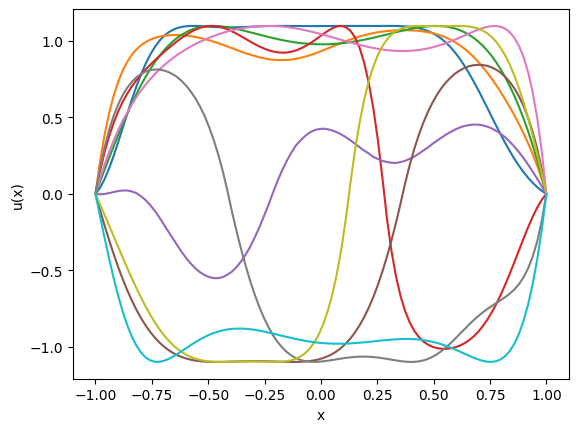

In [42]:
uk_sampled = uk[:, ::5]  # shape: (Nu, Nx/5)

# create dataset (input=uk_sampled, target=uk)
train_dataset = TensorDataset(uk_sampled, uk)

# create DataLoader (shuffling and batching)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# plot first 10 curves
for i in range(10):
    plt.plot(X[:, 0].cpu().numpy(), uk[i, :].cpu().numpy())
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()

### Training

In [46]:
epochs = 1000
X_dev = X.to(device)

for epoch in range(epochs):
    for uks_b, uk_b in dl:
        uks_b = uks_b.to(device)
        uk_b = uk_b.to(device)
        optimizer.zero_grad()
        x_in = X_dev.clone().detach().requires_grad_(True)
        L_energy, L_distance = physics_informed_loss_sampled(u_onet, uks_b, uk_b, x_in, eps, tao)
        loss = L_energy + L_distance
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}] ',
              f'Loss: {loss.item():.4f}, L_energy: {L_energy.item():.4f}, L_distance: {L_distance.item():.4f}')


Epoch [100/1000]  Loss: 14.8399, L_energy: 11.4638, L_distance: 3.3761
Epoch [200/1000]  Loss: 12.2671, L_energy: 10.6693, L_distance: 1.5978
Epoch [300/1000]  Loss: 12.5863, L_energy: 11.2225, L_distance: 1.3638
Epoch [400/1000]  Loss: 12.1098, L_energy: 11.1097, L_distance: 1.0001
Epoch [500/1000]  Loss: 13.1737, L_energy: 11.5256, L_distance: 1.6480
Epoch [600/1000]  Loss: 12.1356, L_energy: 10.7095, L_distance: 1.4261
Epoch [700/1000]  Loss: 12.4313, L_energy: 11.1552, L_distance: 1.2761
Epoch [800/1000]  Loss: 12.0184, L_energy: 11.1121, L_distance: 0.9062
Epoch [900/1000]  Loss: 12.2882, L_energy: 11.0450, L_distance: 1.2432
Epoch [1000/1000]  Loss: 11.8982, L_energy: 10.8145, L_distance: 1.0837


### Quick evaluation and plot

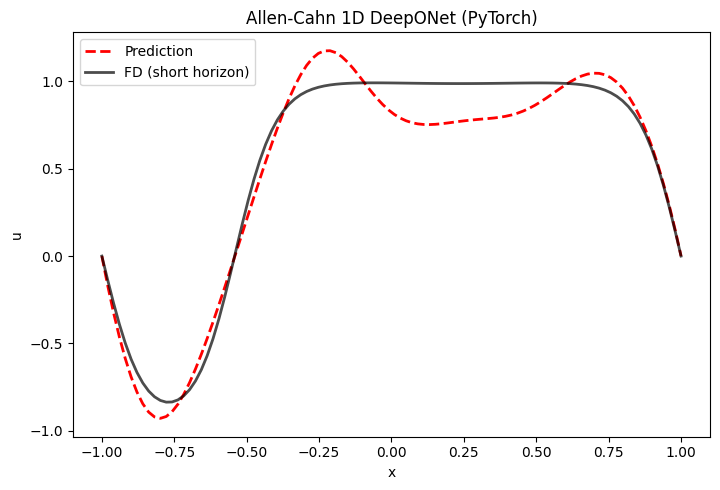

In [48]:
@torch.no_grad()
def allen_cahn_fd(u0: np.ndarray, eps: float, dt: float, dx: float) -> np.ndarray:
    Nx = u0.shape[0]
    ut = np.zeros(Nx, dtype=np.float32)
    ut[0] = 0.0
    ut[-1] = 0.0
    for i in range(1, Nx - 1):
        ut[i] = u0[i] + dt * (((u0[i - 1] - 2 * u0[i] + u0[i + 1]) / (dx**2)) + (u0[i] - u0[i] ** 3) / (eps**2))
    return ut

u_onet.eval()
kk = np.random.randint(0, Nu)
with torch.no_grad():
    x_in = X_dev.clone().detach().requires_grad_(False)
    u_pred = u_onet(uk_sampled[kk:kk+1].to(device), x_in, return_grad=False)[0].cpu().numpy()

# finite-difference rollout for a short horizon
dt = 5e-5
dx = float(X[1, 0] - X[0, 0])
u_exact = uk[kk].cpu().numpy()
steps = int(0.02 / dt)
for _ in range(steps):
    u_exact = allen_cahn_fd(u_exact, eps, dt, dx)

X_plot = X[:, 0].cpu().numpy()
plt.figure(figsize=(7.3, 5.0))
plt.plot(X_plot, u_pred, 'r--', linewidth=2, label='Prediction')
plt.plot(X_plot, u_exact, 'k', linewidth=2, alpha=0.7, label='FD (short horizon)')
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title('Allen-Cahn 1D DeepONet (PyTorch)'); plt.tight_layout()
plt.show()
